## Import The Needed Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preprocessing

In [ ]:
df = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

filtered_df = df[df['Label'].isin(['BENIGN', 'DoS Hulk'])]
filtered_df['Label'] = filtered_df['Label'].map({'BENIGN': 0, 'DoS Hulk': 1})


## Feature Selection Using Mutual Information

In [ ]:
X = filtered_df.drop(columns=['Label'])
y = filtered_df['Label']

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)

top_10_features = mi_series.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 features based on MI scores:\n", top_10_features)

X_top_10 = X[top_10_features]


## Define Multi-Channel Neural Network Model

In [ ]:
input_channels = []
for feature in top_10_features:
    input_layer = layers.Input(shape=(1,), name=f"input_{feature}")
    input_channels.append(input_layer)

feature_layers = []
for input_channel in input_channels:
    dense_layer = layers.Dense(16, activation='relu')(input_channel)
    feature_layers.append(dense_layer)

concat_layer = layers.concatenate(feature_layers)
dense_layer = layers.Dense(32, activation='relu')(concat_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dense_layer)

model = models.Model(inputs=input_channels, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


## Data Splitting and Model Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_top_10, y, test_size=0.2, random_state=42)

train_inputs = [X_train[feature].values.reshape(-1, 1) for feature in top_10_features]
test_inputs = [X_test[feature].values.reshape(-1, 1) for feature in top_10_features]

history = model.fit(train_inputs, y_train, epochs=5, batch_size=32, validation_split=0.2)


## Model Evaluation and Predictions

In [ ]:
y_pred = model.predict(test_inputs)
y_pred = (y_pred > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


## Visualization of Training Progress

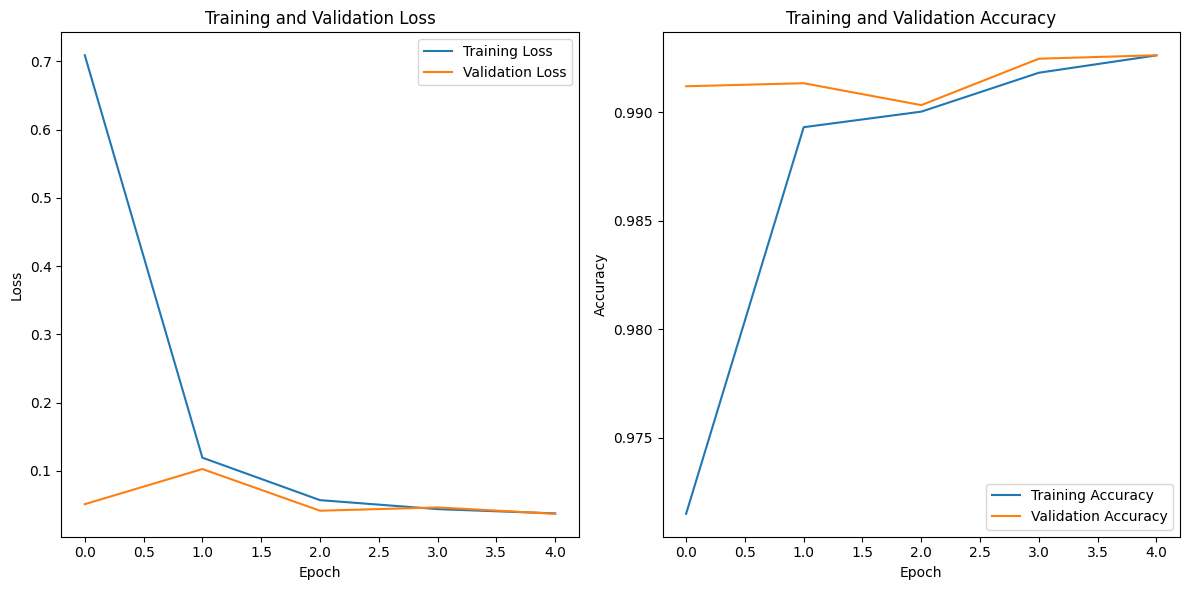

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
